---
---
# NEURAL STYLE TRANSFER
---
---

# STEP 1 - Generating The Content
* E.g. given an image, can we recrate the same image

In [10]:
#from __future__ import print_function, division
#from builtins import range, input
#
#import tensorflow as tf
#
#from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
##from keras.layers.convolutional import Conv2D
#from tensorflow.keras.models import Model, Sequential
#from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
#from tensorflow.keras.preprocessing import image
#import tensorflow.keras.backend as K #we can't use fit function, we need this to reach gradients to use gradient descent or another loss
#import matplotlib.pyplot as plt 
#import numpy as np
#from scipy.optimize import fmin_l_bfgs_b #key algorithm
#
#from __future__ import print_function, division
#from builtins import range, input
#
#
#from keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
##from keras.layers.convolutional import Conv2D
#from keras.models import Model, Sequential
#from keras.applications.vgg16 import VGG16, preprocess_input
#from keras.preprocessing import image
#import keras.backend as K #we can't use fit function, we need this to reach gradients to use gradient descent or another loss
#import matplotlib.pyplot as plt 
#import numpy as np
#from scipy.optimize import fmin_l_bfgs_b #key algorithm

In [11]:
from __future__ import print_function, division
from builtins import range, input

import tensorflow as tf

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt 
import numpy as np
from scipy.optimize import fmin_l_bfgs_b

In [12]:
def VGG16_AvgPool(shape):
    #we want to account for features across the entire image
    #so we get rid of the maxpool which throws away information
    #NOT: we still lose some information but as much as maxpooling
    vgg = VGG16(input_shape=shape,
                weights='imagenet',
                include_top=False)
    #Functional API
    input_ = vgg.input
    x = input_ # start from input
    # first layer is input, therefore start from 2nd index
    for layer in vgg.layers[1:]:
        if isinstance(layer, MaxPooling2D):
            #replace it with average pooling
            x = AveragePooling2D(pool_size=(2, 2), 
                                 strides=(2, 2), 
                                 padding='valid')(x)
        else:
            x = layer(x)
    # we have a graph network now. -> .input and .output can be use
    model = Model(inputs=input_, outputs=x, name="vgg16_avgpool")
    return model

In [13]:
def VGG16_AvgPool_CutOff(shape, num_convs):
    # there are 13 convolutions in vgg16 total
    # we can pick any of them as the "output"
    # of our content model
    if num_convs < 1 or num_convs > 13:
        print("num_convs must be in the range [1,13]")
        return None
    #create average pooling vgg
    base_model = VGG16_AvgPool(shape)

    # count conv2d
    conv_count = 0
    cutoff_layer = None

    for layer in base_model.layers:
        if isinstance(layer, Conv2D):
            conv_count+=1
            if conv_count == num_convs:
                cutoff_layer = layer
                break
    if cutoff_layer is None:
        raise ValueError("Could not find the requested Conv2D layer.")

    cut_model = Model(inputs=base_model.input,
                      outputs=cutoff_layer.output,
                      name=f"vgg16_avgpool_cutoff_{num_convs}")    
    return cut_model

In [14]:
# vgg expects caffe format. In coffe format, 
# RGB is converted to BGR and the channel average 
# used in ImageNet training is extracted from each channel.
def unpreprocess(img):
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 126.68
    img = img[..., ::-1]
    return img

# It performs min-max normalization by setting 
# the minimum of the image (or a gradient map) 
# to 0 and the maximum to 1.
# This is especially useful when 
# visualizing gradients or feature maps; 
# regardless of the value range, 
# the image is normalized and becomes visible on the screen.
def scale_img(x):
    x = x - x.min()
    x = x / x.max()
    return x

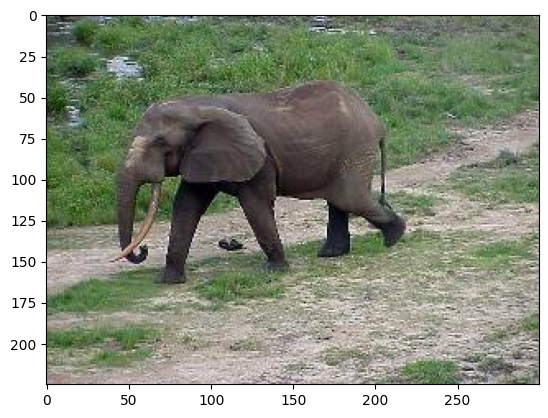

In [20]:
#load an img
path = '/kaggle/input/dataset/Data/elephant.jpg'
img = image.load_img(path)

#convert img to array and preprocess for vgg
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

#we will use this throuht the rest of the script
x_content = x # save photo
batch_shape = x.shape # hxwxc     #c: colour
shape = x.shape[1:]   # 1xhxwxc

#see the image
plt.imshow(img)
plt.show()

In [16]:
# -----------------------------
# Content model & target
# -----------------------------

#select a cutoff to see the image that result
content_model = VGG16_AvgPool_CutOff(shape=shape, 
                                     num_convs=11)
# make the target
target = content_model(x) # shape: (1, h, w, c)
target = tf.stop_gradient(target) # keep it steady during optimization

# -----------------------------
# Loss + Gradient fonksiyonu
# -----------------------------
batch_shape = x.shape  # (1, H, W, 3)

def loss_and_grads(x_flat):
    """
    x_flat: flattened image (numpy 1D)
    return: (loss_value, grads_flat)
    """
    # 1) Change x_flat back to (1, H, W, 3)
    x_in = tf.reshape(x_flat, batch_shape)
    with tf.GradientTape() as tape:
        tape.watch(x_in)
        feats = content_model(x_in)
        #we are using all TF ops here, no KerasTensor
        loss_value = tf.reduce_mean(tf.square(feats - target))
    grads = tape.gradient(loss_value, x_in)
    # For SciPy, return numpy float and flattened grad
    loss_value = loss_value.numpy().astype('float64')
    grads = grads.numpy().flatten().astype('float64')
    return loss_value, grads

min: -127.0  max: 127.0
iter=0, loss=988.0382690429688
min: -127.0  max: 127.0
iter=1, loss=371.13055419921875
min: -127.0  max: 127.0
iter=2, loss=218.8235321044922
min: -127.0  max: 127.0
iter=3, loss=153.5972900390625
min: -127.0  max: 127.0
iter=4, loss=116.91484069824219
min: -127.0  max: 127.0
iter=5, loss=95.82946014404297
min: -127.0  max: 127.0
iter=6, loss=82.5120620727539
min: -127.0  max: 127.0
iter=7, loss=73.07234954833984
min: -127.0  max: 127.0
iter=8, loss=65.84725952148438
min: -127.0  max: 127.0
iter=9, loss=59.79306411743164
min: -127.0  max: 127.0
iter=10, loss=54.87366485595703
min: -127.0  max: 127.0
iter=11, loss=51.10655212402344
min: -127.0  max: 127.0
iter=12, loss=47.28789138793945
min: -127.0  max: 127.0
iter=13, loss=44.15177917480469
min: -127.0  max: 127.0
iter=14, loss=41.918636322021484
min: -127.0  max: 127.0
iter=15, loss=39.92914962768555
min: -127.0  max: 127.0
iter=16, loss=37.56590270996094
min: -127.0  max: 127.0
iter=17, loss=35.74934768676758


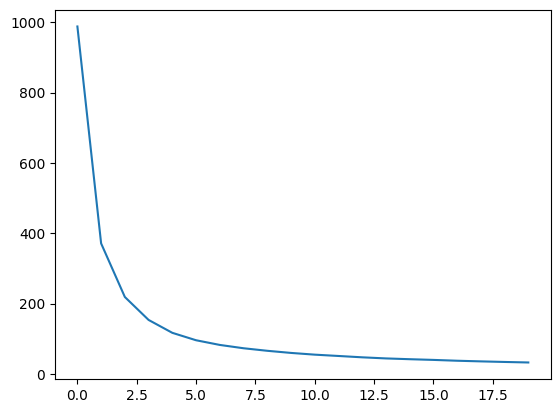

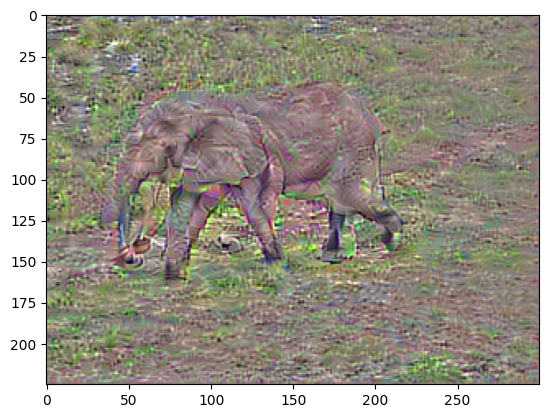

In [17]:
from datetime import datetime
t0=datetime.now()
losses = []
x = np.random.randn(np.prod(batch_shape))
#x = x.flatten().astype('float64')
for i in range(20):
    x, l, _ = fmin_l_bfgs_b(func=loss_and_grads,
                            x0=x,
                            #bounds=[[-127,127]* len(x.flatten())]
                            maxfun =20) 
    x = np.clip(x,-127, 127)
    print("min:", x.min(), " max:", x.max())
    print("iter=%s, loss=%s" % ((i,l)))
    losses.append(l)

print("duration:", datetime.now() - t0)
plt.plot(losses)
plt.show()

new_img = x.reshape(*batch_shape)
final_img=unpreprocess(new_img)

plt.imshow(scale_img(final_img[0]))
plt.show()

iter=0, loss=109.12132263183594, min=-44.017971310795, max=127.0


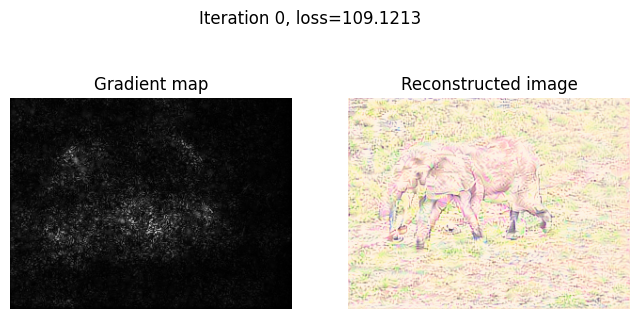

iter=1, loss=126.75447845458984, min=-62.1402671043861, max=127.0


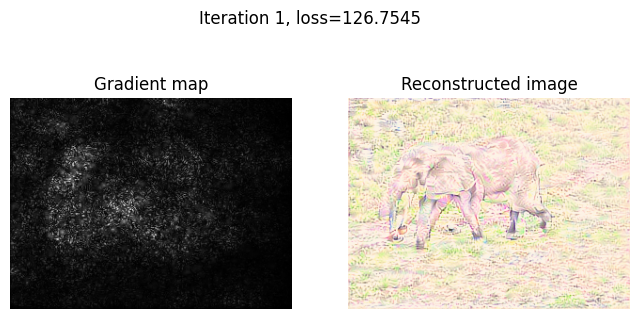

iter=2, loss=98.32453155517578, min=-63.80669606547928, max=127.0


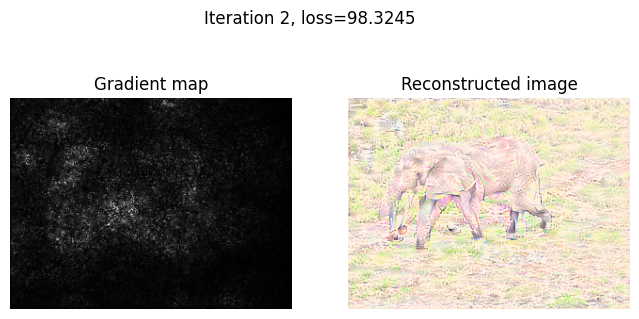

iter=3, loss=76.58277893066406, min=-69.37885969960885, max=127.0


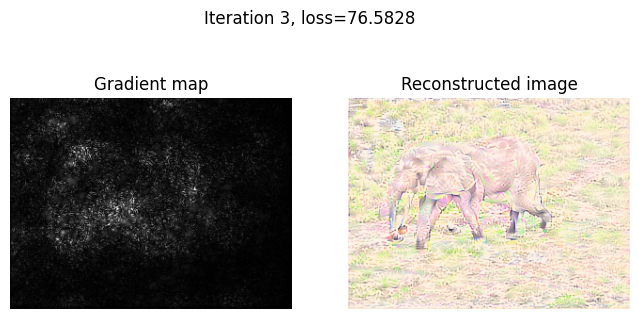

iter=4, loss=68.03355407714844, min=-69.15094186856881, max=127.0


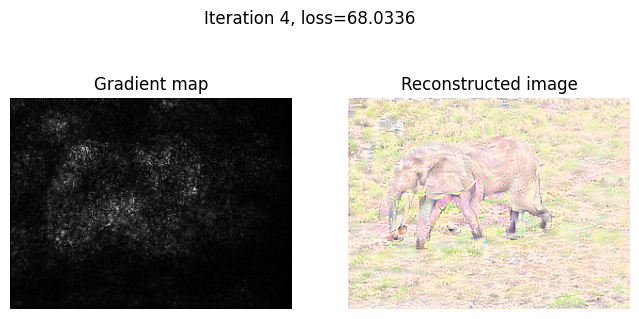

iter=5, loss=59.147972106933594, min=-71.4976658272467, max=127.0


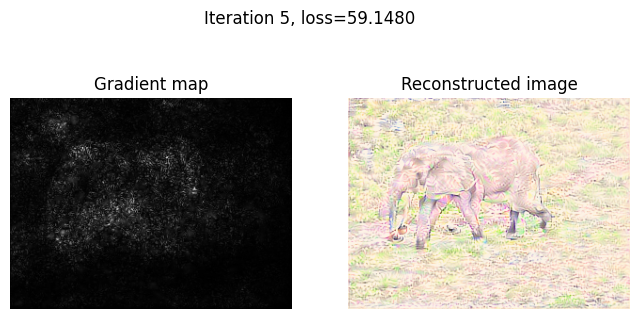

iter=6, loss=55.003990173339844, min=-74.95019877636784, max=127.0


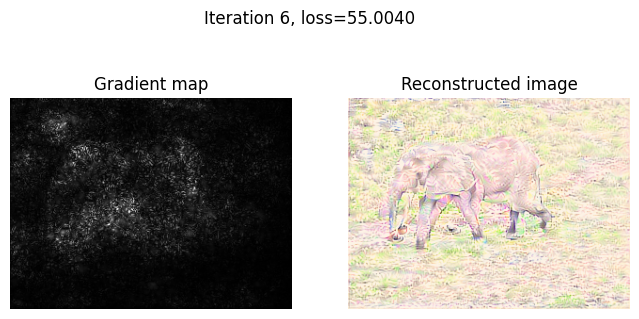

iter=7, loss=49.863380432128906, min=-80.06732387182645, max=127.0


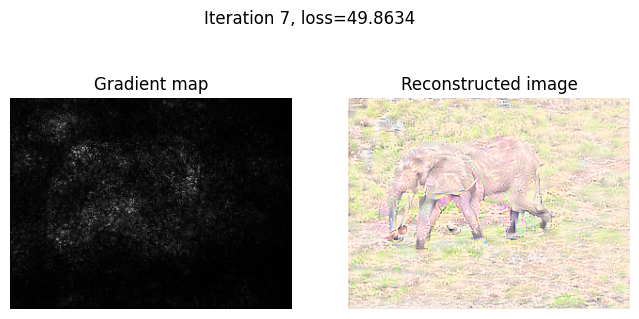

iter=8, loss=47.10806655883789, min=-83.42076091203309, max=127.0


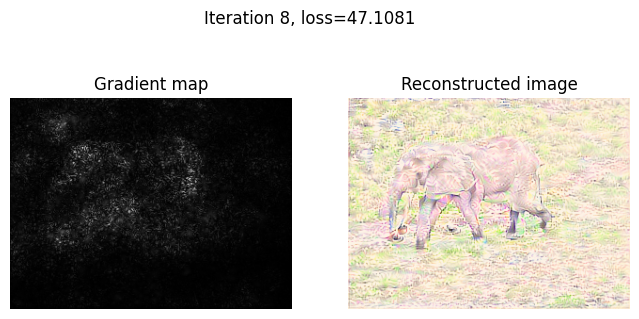

iter=9, loss=44.324886322021484, min=-86.52109322114315, max=127.0


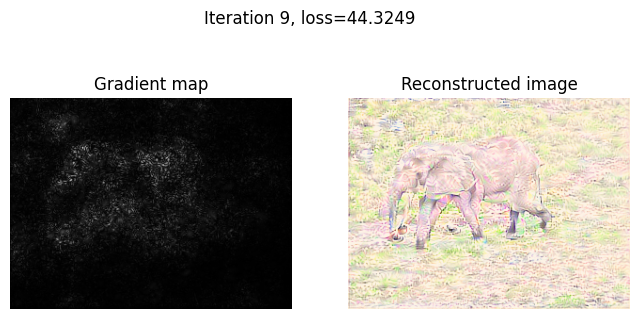

duration: 0:00:18.291478


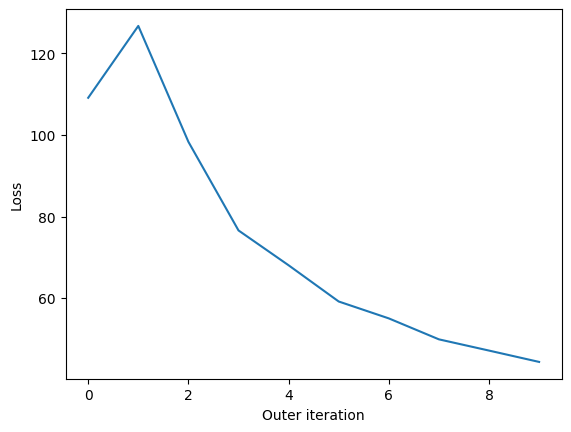

iter=0, loss=947.9468383789062, min=-127.0, max=127.0


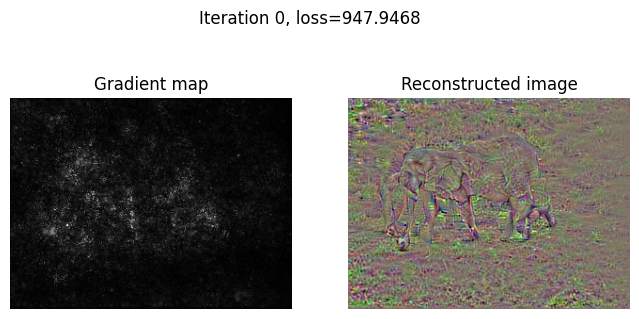

iter=1, loss=355.83428955078125, min=-127.0, max=127.0


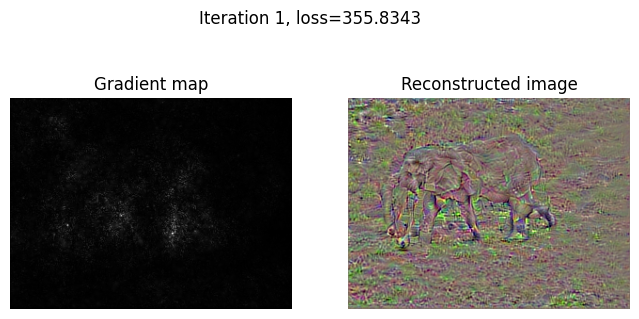

iter=2, loss=206.8740692138672, min=-127.0, max=127.0


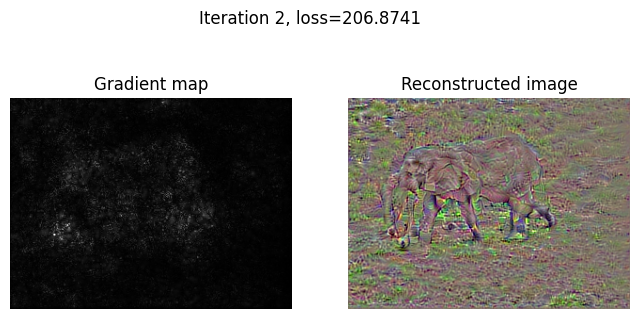

iter=3, loss=149.84654235839844, min=-127.0, max=127.0


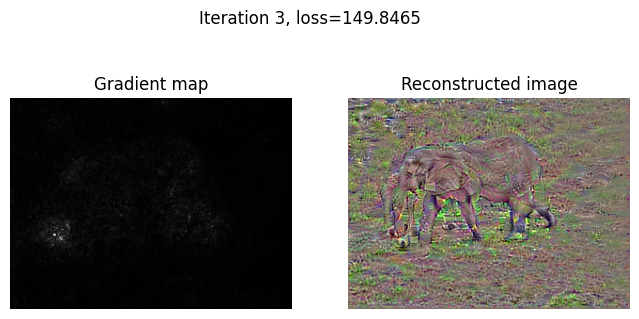

iter=4, loss=117.58308410644531, min=-127.0, max=127.0


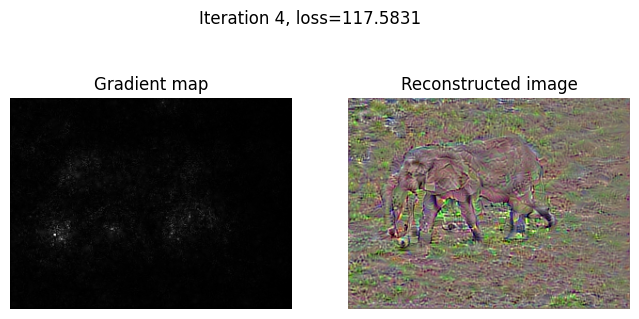

iter=5, loss=94.11550903320312, min=-127.0, max=127.0


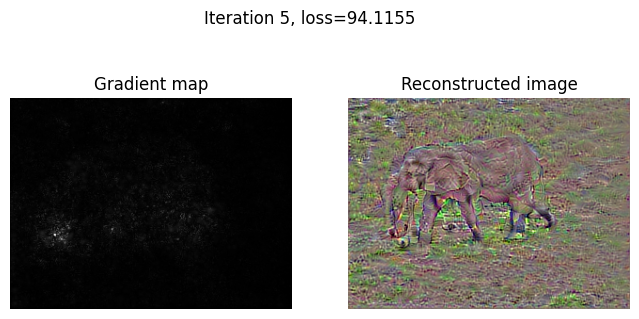

iter=6, loss=79.88951873779297, min=-127.0, max=127.0


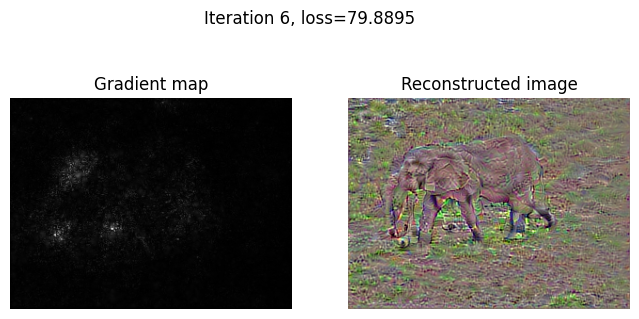

iter=7, loss=69.11763000488281, min=-127.0, max=127.0


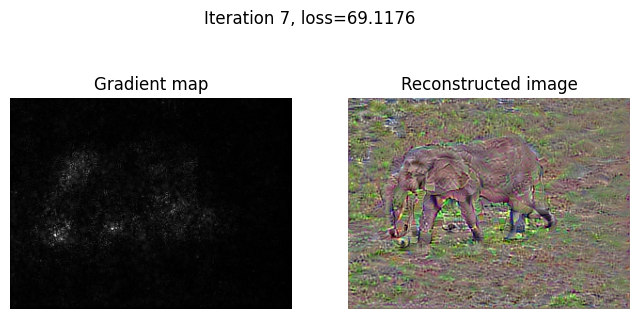

iter=8, loss=61.19814682006836, min=-127.0, max=127.0


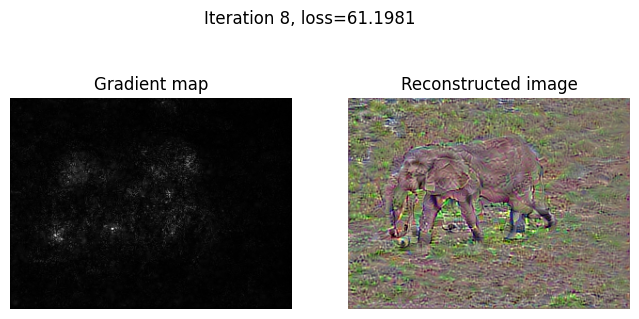

iter=9, loss=55.006343841552734, min=-127.0, max=127.0


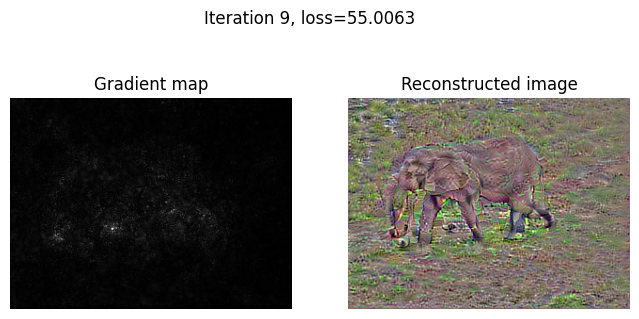

duration: 0:00:18.146661


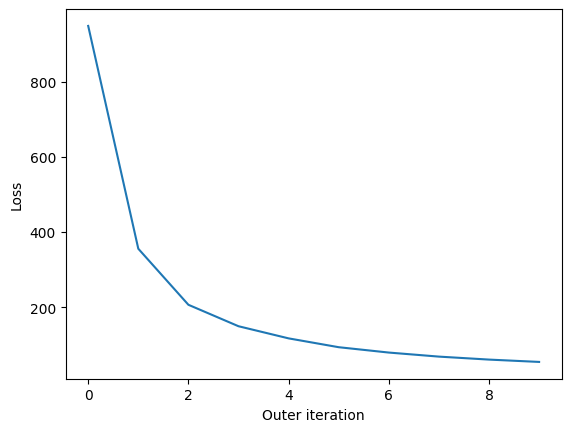

In [18]:
#advaced function
from datetime import datetime

def run_lbfgs_with_vis(use_random_init=False,
                       outer_iters=10,
                       maxfun=20):
    """
    use_random_init = False -> x (content image) ile başlar
    use_random_init = True  -> random gürültü ile başlar
    """
    global x, batch_shape  # x: preprocess_input sonrası içerik resmi

    # --- başlangıç vektörü ---
    if use_random_init:
        x_vec = np.random.randn(np.prod(batch_shape)).astype("float64")
    else:
        x_vec = x.flatten().astype("float64")

    t0 = datetime.now()
    losses = []

    for i in range(outer_iters):
        # L-BFGS adımı
        x_vec, l, _ = fmin_l_bfgs_b(
            func=loss_and_grads,
            x0=x_vec,
            maxfun=maxfun
        )
        x_vec = np.clip(x_vec, -127, 127)

        print(f"iter={i}, loss={l}, min={x_vec.min()}, max={x_vec.max()}")
        losses.append(l)

        # ---- Görselleştirme: gradient + image ----
        # Gradient map için mevcut x_vec ile loss_and_grads çağır
        _, grads_flat = loss_and_grads(x_vec)
        grad_img = grads_flat.reshape(batch_shape)   # (1, H, W, 3)

        # Channel ortalamasını alıp normalize edelim (gradient map)
        grad_mag = np.mean(np.abs(grad_img[0]), axis=-1)  # (H, W)
        grad_vis = scale_img(grad_mag)

        # Görüntü
        img_cur = x_vec.reshape(batch_shape)
        img_cur = unpreprocess(img_cur.copy())
        img_vis = np.clip(img_cur[0], 0, 255).astype("uint8")

        plt.figure(figsize=(8, 4))
        plt.suptitle(f"Iteration {i}, loss={l:.4f}")

        plt.subplot(1, 2, 1)
        plt.title("Gradient map")
        plt.imshow(grad_vis, cmap="gray")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.title("Reconstructed image")
        plt.imshow(img_vis)
        plt.axis("off")

        plt.show()
        # -----------------------------------------

    print("duration:", datetime.now() - t0)

    # Loss grafiği
    plt.figure()
    plt.plot(losses)
    plt.xlabel("Outer iteration")
    plt.ylabel("Loss")
    plt.show()

    # Final image return
    final_img = x_vec.reshape(batch_shape)
    final_img = unpreprocess(final_img.copy())
    return final_img

# İçerik resminden başla:
final_from_content = run_lbfgs_with_vis(use_random_init=False)

# Random gürültüden başla:
final_from_noise = run_lbfgs_with_vis(use_random_init=True)


todo: başka layerları dene

In [33]:
from datetime import datetime

def select_conv2d_and_create_context(
    num_convs=11,
    use_random_init=False,
    outer_iters=20,
    maxfun=20,
    silent=False
):
    """
    num_convs      : Kaçıncı Conv2D katmanında kesileceğini seç (1–13 arası).
    use_random_init: False -> içerik resminden başlar, True -> random gürültü.
    outer_iters    : fmin_l_bfgs_b'yi kaç defa dış döngüde çağıracağın.
    maxfun         : Her L-BFGS çağrısında max fonksiyon değerlendirmesi.
    silent         : False -> her iterasyonu print et, True -> iterasyon içi print yok.
    """
    global x, batch_shape  # x: preprocess_input(img) sonrası

    # x daha önce flatten edildiyse geri 4D'ye çevir
    if x.ndim == 1:
        x_content = x.reshape(batch_shape)
    else:
        x_content = x

    batch_shape = x_content.shape  # (1, H, W, 3)
    h_w_c = batch_shape[1:]        # (H, W, 3)

    # Seçilen conv katmanına kadar kesilmiş modeli oluştur
    content_model = VGG16_AvgPool_CutOff(shape=h_w_c, num_convs=num_convs)

    # Target feature map: orijinal içerik resminden
    target = content_model(x_content)
    target = tf.stop_gradient(target)

    # Bu modele özel loss+grads fonksiyonu
    def loss_and_grads_local(x_flat):
        x_in = tf.reshape(x_flat, batch_shape)

        with tf.GradientTape() as tape:
            tape.watch(x_in)
            feats = content_model(x_in)
            loss_value = tf.reduce_mean(tf.square(feats - target))

        grads = tape.gradient(loss_value, x_in)

        loss_value = loss_value.numpy().astype("float64")
        grads = grads.numpy().flatten().astype("float64")
        return loss_value, grads

    # Başlangıç: içerik ya da random
    if use_random_init:
        x_vec = np.random.randn(np.prod(batch_shape)).astype("float64")
    else:
        x_vec = x_content.flatten().astype("float64")

    t0 = datetime.now()
    losses = []

    # Dış döngü: L-BFGS adımları
    for i in range(outer_iters):
        x_vec, l, _ = fmin_l_bfgs_b(
            func=loss_and_grads_local,
            x0=x_vec,
            maxfun=maxfun
        )
        x_vec = np.clip(x_vec, -127, 127)
        losses.append(l)

        if not silent:
            print(f"iter={i}, loss={l}, min={x_vec.min()}, max={x_vec.max()}")

    # Bu kısım her zaman print edilecek
    print("duration:", datetime.now() - t0)
    print(f"final loss: {losses[-1]}")

    # --- Final durumda gradient map ---
    _, grads_flat = loss_and_grads_local(x_vec)
    grad_img = grads_flat.reshape(batch_shape)           # (1, H, W, 3)
    grad_mag = np.mean(np.abs(grad_img[0]), axis=-1)     # (H, W)
    grad_vis = scale_img(grad_mag)                       # 0–1 normalize

    # --- Final reconstructed image (tam senin pipeline'ın) ---
    img_cur = x_vec.reshape(batch_shape)                 # (1, H, W, 3)
    final_img = unpreprocess(img_cur.copy())             # BGR->RGB + mean ekle
    recon_vis = scale_img(final_img[0])                  # min-max normalize

    # --- 3 subplot: Loss, Gradient map, Reconstructed image ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # 1) Loss grafiği
    axes[0].plot(losses)
    axes[0].set_title("Loss over iterations")
    axes[0].set_xlabel("Outer iteration")
    axes[0].set_ylabel("Loss")

    # 2) Gradient map
    axes[1].imshow(grad_vis, cmap="gray")
    axes[1].set_title(f"Gradient map (conv {num_convs})")
    axes[1].axis("off")

    # 3) Reconstructed image (orijinalle aynı tarzda)
    axes[2].imshow(recon_vis)
    axes[2].set_title("Reconstructed image")
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()

    # Final vektör ve loss listesi geri döndürülüyor
    return x_vec, losses


iter=0, loss=0.0, min=-2.990722663298584e-06, max=127.0
iter=1, loss=94.31431579589844, min=-39.068986876558945, max=127.0
iter=2, loss=58.491512298583984, min=-52.12005918678445, max=127.0
iter=3, loss=45.05962371826172, min=-58.79945545653411, max=127.0
iter=4, loss=36.027732849121094, min=-68.76376057238582, max=127.0
iter=5, loss=30.593896865844727, min=-75.59873181712707, max=127.0
iter=6, loss=26.18411636352539, min=-80.04212978534397, max=127.0
iter=7, loss=23.520545959472656, min=-82.98667726970874, max=127.0
iter=8, loss=22.364347457885742, min=-84.52608366259068, max=127.0
iter=9, loss=18.883638381958008, min=-87.80154086875883, max=127.0
iter=10, loss=18.81075096130371, min=-88.95606388772639, max=127.0
iter=11, loss=16.350814819335938, min=-91.43815795272606, max=127.0
iter=12, loss=16.054758071899414, min=-92.38298162624253, max=127.0
iter=13, loss=14.776320457458496, min=-94.11282986733382, max=127.0
iter=14, loss=14.063675880432129, min=-95.04203763750168, max=127.0
iter

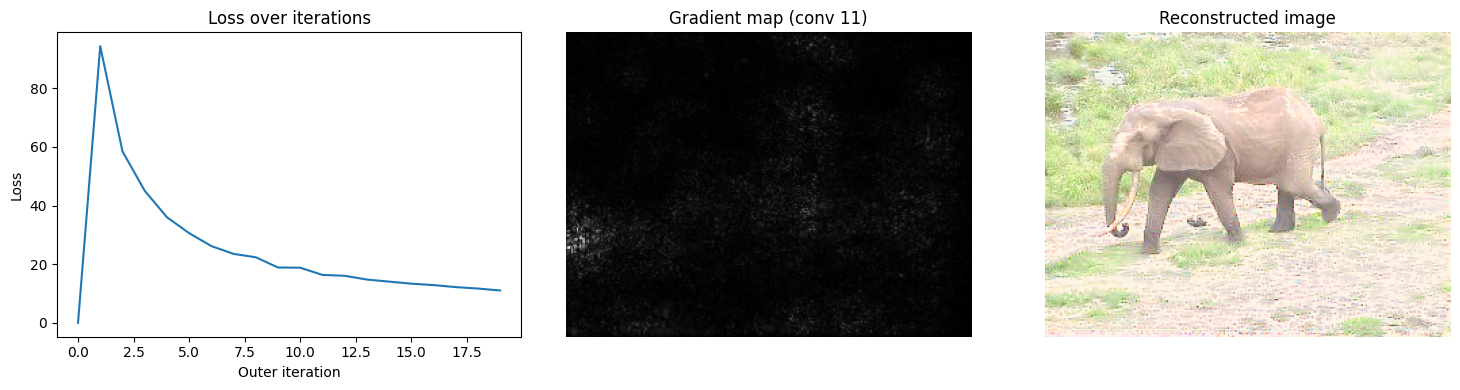

duration: 0:00:21.211419
final loss: 4705.3310546875


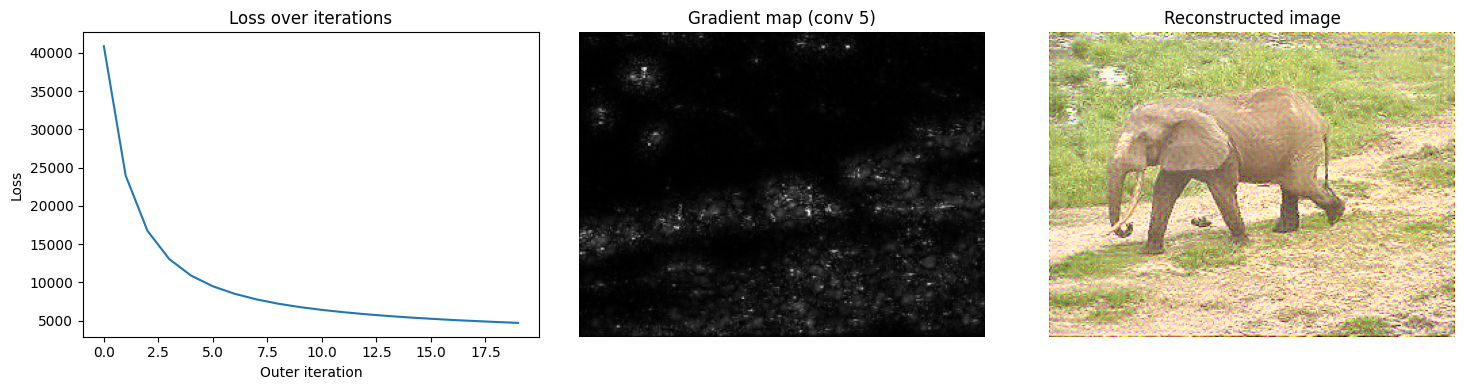

In [34]:
# 11. Conv katmanına kadar, içerik resminden başla, gürültü yok, iterasyonları yaz:
x_final, losses = select_conv2d_and_create_context(
    num_convs=11,
    use_random_init=False,
    outer_iters=20,
    maxfun=20,
    silent=False
)

# 5. Conv katmanına kadar, random init, sessiz mod:
x_final_rand, losses_rand = select_conv2d_and_create_context(
    num_convs=5,
    use_random_init=True,
    outer_iters=20,
    maxfun=20,
    silent=True
)


iter=0, loss=1486.493408203125, min=-127.0, max=127.0
iter=1, loss=631.8113403320312, min=-127.0, max=127.0
iter=2, loss=371.1717529296875, min=-127.0, max=127.0
iter=3, loss=270.98895263671875, min=-127.0, max=127.0
iter=4, loss=210.9743194580078, min=-127.0, max=127.0
iter=5, loss=176.70262145996094, min=-127.0, max=127.0
iter=6, loss=149.80152893066406, min=-127.0, max=127.0
iter=7, loss=133.01516723632812, min=-127.0, max=127.0
iter=8, loss=119.39366149902344, min=-127.0, max=127.0
iter=9, loss=109.32160949707031, min=-127.0, max=127.0
iter=10, loss=102.14265441894531, min=-127.0, max=127.0
iter=11, loss=94.97904205322266, min=-127.0, max=127.0
iter=12, loss=89.14214324951172, min=-127.0, max=127.0
iter=13, loss=84.30601501464844, min=-127.0, max=127.0
iter=14, loss=80.39322662353516, min=-127.0, max=127.0
iter=15, loss=77.26380920410156, min=-127.0, max=127.0
iter=16, loss=74.34976196289062, min=-127.0, max=127.0
iter=17, loss=71.74302673339844, min=-127.0, max=127.0
iter=18, loss

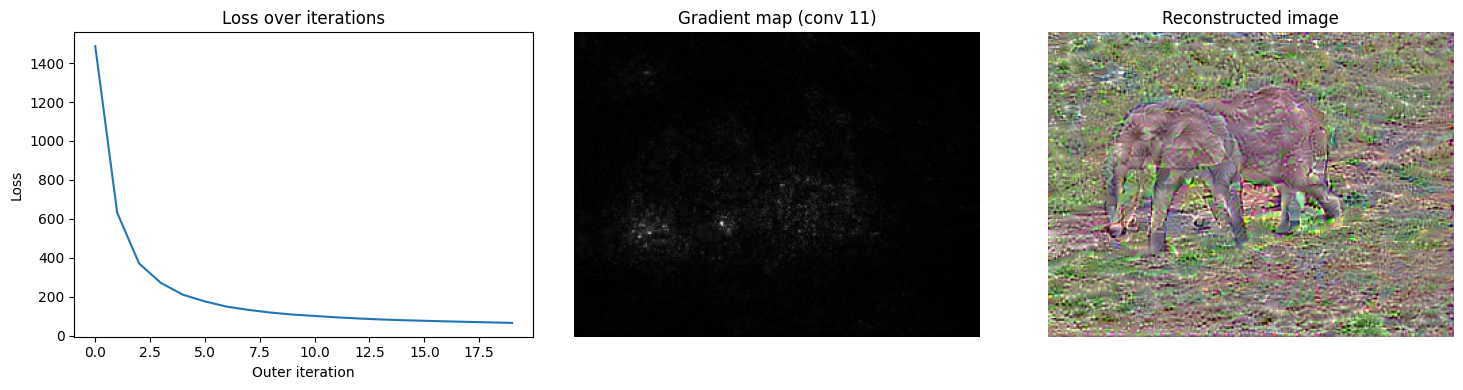

In [35]:
x_final, losses = select_conv2d_and_create_context(
    num_convs=11,
    use_random_init=True,
    outer_iters=20,
    maxfun=20,
    silent=False
)